In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, maxabs_scale
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import pearsonr
import keras.backend as K
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from model import MeronSmart, ml_models,plot_confusion_matrix

In [3]:
merged_wfh = pd.read_csv('/data/meron/kenya_data/meron_merged_wfh.csv')
meta_data = pd.read_csv('/data/meron/kenya_data/meron_link_data/meron_meta_processed.csv')

In [5]:
merged_wfh.shape

(3594, 2052)

In [4]:
meron = MeronSmart()

In [5]:
regression_model = meron.build_model()

In [6]:
regression_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                131264    
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                3120      
_________________________________________________________________
activation_2 (Activation)    (None, 48)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                588       
__________

In [7]:
merged_wfh = merged_wfh[merged_wfh['wfh'] < 4]

In [8]:
target=merged_wfh['wfh']

target_centered=target-np.mean(target)
sns.distplot(target_centered)

In [9]:
target_scaler = StandardScaler().fit(target.reshape(-1,1))
target_norm=target_scaler.transform(target.reshape(-1,1))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [10]:
deselect_cols = ['photo_id','wfh']
select = [x for x in merged_wfh.columns if x not in deselect_cols]
data_features = merged_wfh.loc[:, select]
data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,gender_male,age_months
0,0.010161,0.244977,0.000000,0.146481,3.627992,0.000000,4.934372,5.038579,0.000000,0.011782,...,0.269243,0.000000,0.0,8.513610,0.000000,0.000000,0.000000,0.026938,1,26.0
1,0.000000,0.000000,0.033809,0.000000,1.634073,0.007764,3.982176,1.657495,0.021575,0.151407,...,0.234539,0.284947,0.0,4.031464,0.000000,0.000000,2.726557,0.149685,0,32.0
2,0.485405,0.075956,1.195641,0.803847,0.134891,0.073037,3.987601,11.776036,0.000000,0.000000,...,0.000000,0.000000,0.0,5.221664,1.326829,0.000000,0.000000,0.000000,0,12.0
3,0.000000,7.703766,0.000000,1.107813,0.000000,0.000000,2.804294,7.715090,0.000000,0.000000,...,0.000000,0.080234,0.0,9.156448,0.013398,0.025511,0.110399,1.820649,0,51.0
4,0.214333,2.559898,1.654353,1.902321,0.600150,1.964184,3.426954,9.696762,0.000000,0.030368,...,0.000000,0.000000,0.0,13.095944,6.709367,0.000000,1.413408,0.487794,0,13.0


# Split data into training and testing sets, then train model

In [11]:
### scale/standardize the features?
conv_scaler = StandardScaler().fit(data_features)
data_features_scaled = conv_scaler.transform(data_features)
data_features_scaled

array([[-0.36035679, -0.30353122, -0.87658675, ..., -0.5579345 ,
         0.97518224, -0.31434157],
       [-0.37120382, -0.47184229, -0.85862433, ..., -0.44106173,
        -1.02544936,  0.08189474],
       [ 0.14698999, -0.41965663, -0.24136037, ..., -0.58358397,
        -1.02544936, -1.23889295],
       ...,
       [ 2.47846592,  0.0838428 , -0.06954757, ...,  0.79544821,
        -1.02544936, -0.1822628 ],
       [-0.37120382, -0.45123325, -0.87658675, ...,  1.14070246,
         0.97518224,  0.14793412],
       [-0.29958818, -0.47184229,  0.92240781, ...,  1.22722864,
        -1.02544936,  0.47813104]])

In [12]:
### Break data into training and test
X_train, X_test, y_train, y_test = train_test_split(data_features_scaled, target_norm, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape)
print(X_test.shape)

(2865, 2050)
(717, 2050)


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('regression_model_resnetfeats_64_48_12(dropout02_scaled).h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

In [19]:
regression_model.fit(X_train,
                y_train,
                epochs=2000,
                batch_size=512,
                callbacks=[checkpoint, early_stop],
                shuffle=True,
                validation_data=(X_test, y_test),
                verbose=1)

Train on 2865 samples, validate on 717 samples
Epoch 1/2000
2865/2865 [==============================] - 0s 43us/step - loss: 0.8873 - pearson_coeff: 0.5548 - val_loss: 1.1152 - val_pearson_coeff: 0.2653

Epoch 00001: val_loss did not improve from 1.11184
Epoch 2/2000
2865/2865 [==============================] - 0s 40us/step - loss: 0.8582 - pearson_coeff: 0.5786 - val_loss: 1.1157 - val_pearson_coeff: 0.2646

Epoch 00002: val_loss did not improve from 1.11184
Epoch 3/2000
2865/2865 [==============================] - 0s 40us/step - loss: 0.8845 - pearson_coeff: 0.5568 - val_loss: 1.1161 - val_pearson_coeff: 0.2643

Epoch 00003: val_loss did not improve from 1.11184
Epoch 4/2000
2865/2865 [==============================] - 0s 52us/step - loss: 0.8558 - pearson_coeff: 0.5833 - val_loss: 1.1161 - val_pearson_coeff: 0.2648

Epoch 00004: val_loss did not improve from 1.11184
Epoch 5/2000
2865/2865 [==============================] - 0s 41us/step - loss: 0.8620 - pearson_coeff: 0.5783 - val_l

# Correlation plot


In [19]:
prediction_centered=regression_model.predict(X_test, verbose=1)

717/717 [==============================] - 0s 139us/step


In [20]:
prediction=target_scaler.inverse_transform(prediction_centered)
y_true=target_scaler.inverse_transform(y_test)

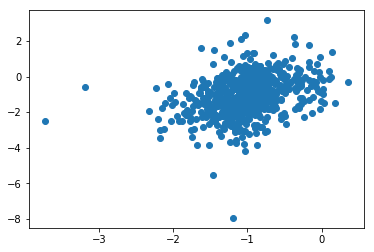

In [21]:
plt.scatter(prediction, y_true)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


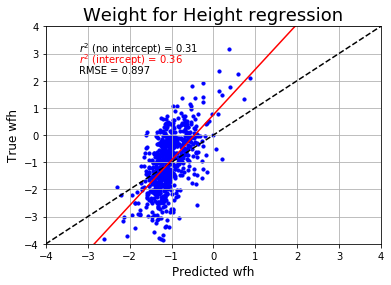

In [98]:
r_pearson, p_val = pearsonr(prediction, y_true)
r_squared_intercept = r_pearson**2
r_squared_no_intercept = r2_score(y_true,prediction)
rmse = np.sqrt(mean_squared_error(y_true, prediction))

# Linear regression
reg_params = stats.linregress(prediction[:,0], y_true[:,0])



y_max = np.max([np.max(y_true), np.max(prediction)])
y_min = np.min([np.min(y_true), np.min(prediction)])

fig, ax = plt.subplots()
sc = ax.scatter(
    prediction, y_true, s=10, edgecolors="blue", color='blue')
ax.set_ylabel(r"True wfh", fontsize=12)
ax.set_xlabel(r"Predicted wfh", fontsize=12)
ax.set_title('Weight for Height regression', fontsize=18)
ax.text(0.1, 0.85, '$r^2$ (intercept) = {0:.2f}'.format(r_squared_intercept[0]), {'color': 'r'},
   ha='left', va='center', transform=ax.transAxes)

ax.text(0.1, 0.9, '$r^2$ (no intercept) = {0:.2f}'.format(r_squared_no_intercept),
    {'color': 'k'}, ha='left', va='center', transform=ax.transAxes)

ax.text(0.1, 0.8, 'RMSE = {0:.3f}'.format(rmse), ha='left', va='center', transform=ax.transAxes)
ax.grid(True)
xplot_vals = np.arange(y_min, y_max + np.floor(y_max / 1))
diag_line, = ax.plot(xplot_vals,
                     xplot_vals,
                     color='k',
                     ls="--",
                     c=".15")

diag_line, = ax.plot(xplot_vals,
                     reg_params[1] + reg_params[0]*xplot_vals,
                     color='r',
                     ls="-",
                     c=".15")

ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])

plt.savefig(
    os.path.join('/data/meron/', 'correlation_plot_wfh.svg'),
    dpi=400
)
plt.show()